# Prophet predictor
This notebook contains a timeseries predictor model built with the fbprophet library. 

## Training

In [1]:
import numpy as np
import pandas as pd

### Copy the data locally

In [2]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [3]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7f93c0c78510>)

In [4]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [5]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [7]:
# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)

In [8]:
# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)

In [9]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']
df = df[id_cols + cases_col + npi_cols]

In [10]:
# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [11]:
# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))

In [12]:
df

,CountryName,RegionName,GeoID,Date,NewCases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
0,Aruba,NaN,Aruba__nan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,NaN,Aruba__nan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,NaN,Aruba__nan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,NaN,Aruba__nan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,NaN,Aruba__nan,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91131,Zimbabwe,NaN,Zimbabwe__nan,2020-11-11,57.0,1.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
91132,Zimbabwe,NaN,Zimbabwe__nan,2020-11-12,29.0,1.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
91133,Zimbabwe,NaN,Zimbabwe__nan,2020-11-13,69.0,1.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
91134,Zimbabwe,NaN,Zimbabwe__nan,2020-11-14,21.0,1.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0


In [12]:
# For testing, restrict training data to that before a hypothetical predictor submission date
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-11-15")
test = df[df.Date > HYPOTHETICAL_SUBMISSION_DATE]
df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [13]:
# install prophet
#!sudo pip install fbprophet

In [15]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


<AxesSubplot:title={'center':'avg daily new cases'}, xlabel='ds'>

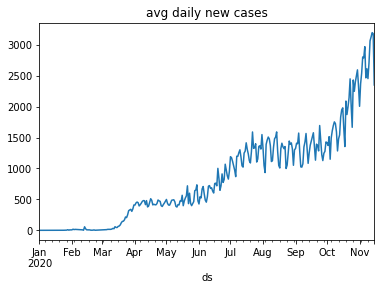

In [16]:
# evaluate prophet time series forecasting model on hold out dataset
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# prepare expected column names
df['ds'] = to_datetime(df['Date'])
df['y'] = df['NewCases']

df.index = df['ds']
df['NewCases'].resample('D').mean().plot(title='avg daily new cases')

In [17]:
# define the model
model = Prophet()
# fit the model
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
# define the period for which we want a prediction
future = list()
for i in range(6,9):
	date = f'2020-11-1{i}'
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)

In [25]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-11-16,2761.886200,-3343.356703,8499.642553,2761.886200,2761.886200,-80.847253,-80.847253,-80.847253,-80.847253,-80.847253,-80.847253,0.0,0.0,0.0,2681.038947
1,2020-11-17,2787.123522,-3349.051897,8272.879355,2787.123522,2787.123522,-11.494785,-11.494785,-11.494785,-11.494785,-11.494785,-11.494785,0.0,0.0,0.0,2775.628737
2,2020-11-18,2812.360844,-2829.986580,8558.557749,2812.330407,2812.360844,49.223778,49.223778,49.223778,49.223778,49.223778,49.223778,0.0,0.0,0.0,2861.584622


In [ ]:
# calculate MAE between expected and predicted values for december
y_true = test['y'][-12:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [33]:
test.CountryName

320         Aruba
321         Aruba
322         Aruba
323         Aruba
324         Aruba
           ...   
91155    Zimbabwe
91156    Zimbabwe
91157    Zimbabwe
91158    Zimbabwe
91159    Zimbabwe
Name: CountryName, Length: 6360, dtype: object